<a href="https://colab.research.google.com/github/Ramotso/Batch-Normalization-vs.-Layer-Normalization/blob/main/Layer_Normalization_vs_Batch_Normalization_on_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 836.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
ERROR: pip'

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [27]:
class NormClassifier(nn.Module):
    def __init__(self, in_dim, feature_dim, out_dim, norm_type="batch"):
        super(NormClassifier, self).__init__()

        if norm_type == "batch":
            norm_layer = nn.BatchNorm1d(feature_dim)
            bias = False  # BN cancels out bias
        elif norm_type == "layer":
            norm_layer = nn.LayerNorm(feature_dim)
            bias = True
        else:
            norm_layer = nn.Identity()
            bias = True

        self.classifier = nn.Sequential(
            nn.Linear(in_dim, feature_dim, bias=bias),
            norm_layer,
            nn.ReLU(),
            nn.Linear(feature_dim, out_dim, bias=True)
        )

    def forward(self, x):
        return self.classifier(x)

In [28]:
torch.manual_seed(42) #For reproducibility
in_dim, feature_dim, out_dim = 784, 256, 10
lr = 1e-3
epochs = 20 #Reduced for faster testing
loss_fn = nn.CrossEntropyLoss()

In [29]:
#Load MNIST dataset
train_dataset = MNIST(".", train=True, download=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [30]:
def run_experiment(norm_type):
    print(f"\nStarting training with {norm_type} normalization...")
    model = NormClassifier(in_dim, feature_dim, out_dim, norm_type=norm_type)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_history = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data = data.flatten(start_dim=1)
            optimizer.zero_grad()
            out = model(data)
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return loss_history

In [31]:
bn_losses = run_experiment("batch")
ln_losses = run_experiment("layer")


Starting training with batch normalization...
Epoch 5/20 - Loss: 0.3898
Epoch 10/20 - Loss: 0.2915
Epoch 15/20 - Loss: 0.2464
Epoch 20/20 - Loss: 0.2191

Starting training with layer normalization...
Epoch 5/20 - Loss: 0.3489
Epoch 10/20 - Loss: 0.2560
Epoch 15/20 - Loss: 0.2143
Epoch 20/20 - Loss: 0.1879


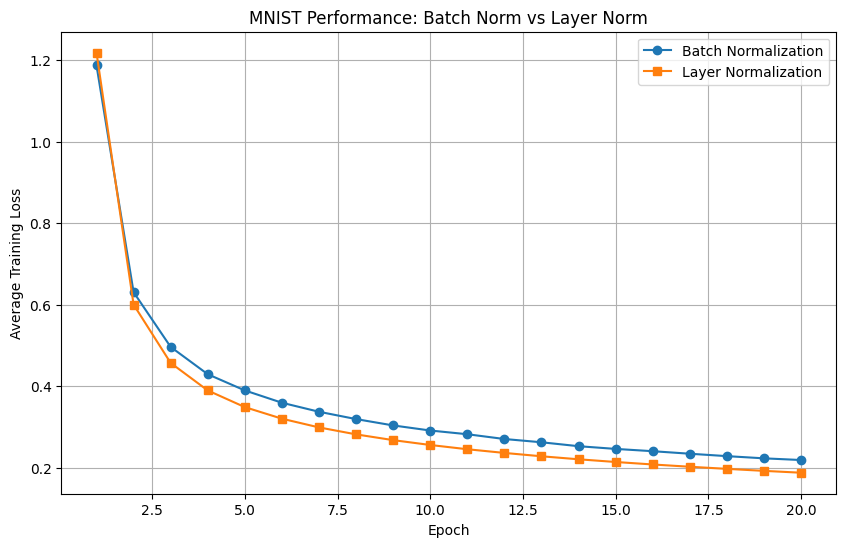

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), bn_losses, label="Batch Normalization", marker='o')
plt.plot(range(1, epochs + 1), ln_losses, label="Layer Normalization", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("MNIST Performance: Batch Norm vs Layer Norm")
plt.legend()
plt.grid(True)
plt.show()